# Working with MEG dataset
MEG dataset from THINGS initiative: https://openneuro.org/datasets/ds004212/versions/2.0.1
### Training data partition
The data is .fif file which needs to be converted into a rather easy to use .npy array.
We will use mne library for this: https://mne.tools/dev/index.html 


We collected extensively sampled object representations using magnetoencephalography (MEG). To this end, we drew on the THINGS database (Hebart et al., 2019), a richly-annotated database of 1,854 object concepts representative of the American English language which contains 26,107 manually-curated naturalistic object images.

ERP = event-related potential; signal with respect to some event
VEP = ERP for visual stimuli



27084 events, 281 time points, 271 channels

## Here we perform NMF experiements. And data matrix as concepts x channes*time

In [1]:
import numpy as np
import mne, os
import matplotlib.pyplot as plt
import pandas as pd
# from tqdm import tqdm
import matplotlib.image as mpimg
import nimfa
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

In [2]:
def fit_bnmf(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=500, min_residuals=1e-4, alpha=np.zeros((V.shape[0], k)),
                        beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=100, stride=1,
                        n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = bnmf_fit.basis()
    H = bnmf_fit.coef()
    return np.array(W), np.array(H)

def compute_evar_all(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    V_hat = np.dot(W, H)
    rss = np.sum(np.asarray(V_hat - V)**2)
    evar_all = 1. - rss / (V*V).sum()
    return evar_all

def compute_evar_indiv(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int):
    V_hat_d = np.outer(W[:, d], H[d, :])
    rss = np.sum(np.asarray(V_hat_d - V)**2)
    evar_indiv = 1. - rss / (V*V).sum()
    return evar_indiv

def compute_evar_unique(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int, evar_all: float):
    V_hat_wo_d = np.dot(W[:, np.arange(W.shape[1]) != d], H[np.arange(H.shape[0]) != d, :])
    rss = np.sum(np.asarray(V_hat_wo_d - V)**2)
    evar_rest = 1. - rss / (V*V).sum()
    evar_unique = evar_all - evar_rest
    return evar_unique

In [3]:
channel_picks = ['O','T','P'] 
preproc_dir = '../data/preprocessed'
image_dir = '../data/'

n_participants = 3
def load_epochs(preproc_dir,all_epochs = []):
    for p in range(1,n_participants+1):
        epochs = mne.read_epochs(f'{preproc_dir}/preprocessed_P{str(p)}-epo.fif', preload=False)
        all_epochs.append(epochs)
    return all_epochs

def plot_erfs(epochs,n_sessions,name):
    ctf_layout = mne.find_layout(epochs.info)
    picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
    picks = np.where([i[2]==name for i in ctf_layout.names])[0]

    # get evoked data
    for s in range(n_sessions):    
        evoked = epochs[(epochs.metadata['trial_type']=='test') & (epochs.metadata['session_nr']==s+1)].average()
        evoked.pick_channels(ch_names=picks_epochs)
        plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=0.5,alpha=0.4)
    evoked = epochs[(epochs.metadata['trial_type']=='test')].average()
    evoked.pick_channels(ch_names=picks_epochs)

    # plot ERFs for selected sensor group
    plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=1)
    plt.xlim([epochs.times[0]*1000,epochs.times[len(epochs.times)-1]*1000])
    plt.ylim([-0.6,0.6])
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV)')  
    # plt.['right'].set_visible(False)
    # plt.spines['top'].set_visible(False)

    #  plot sensor locations
    # ax2.plot(ctf_layout.pos[:,0],ctf_layout.pos[:,1],color='gainsboro',marker='.',linestyle='',markersize=5)
    # ax2.plot(ctf_layout.pos[picks,0],ctf_layout.pos[picks,1],color='grey',marker='.',linestyle='',markersize=5)
    # ax2.set_aspect('equal')


In [4]:
all_epochs = load_epochs(preproc_dir)

Reading /home/asuryawanshi/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


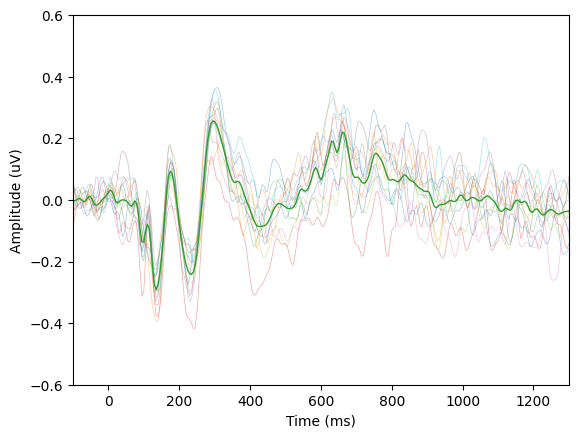

In [5]:
n_sessions = 12
plot_erfs(all_epochs[1],n_sessions,'O')

In [6]:
epochs = all_epochs[2]

In [7]:
epochs.metadata

trial_type  image_nr  category_nr  exemplar_nr  test_image_nr  \
0            exp        66            6            6            NaN   
1            exp     19722         1644            6            NaN   
2            exp      9990          833            6            NaN   
3            exp     18114         1510            6            NaN   
4            exp     21630         1803            6            NaN   
...          ...       ...          ...          ...            ...   
27043       test     22509          874           13           61.0   
27044        exp      1928          161            8            NaN   
27045        exp     12380         1032            8            NaN   
27046        exp      4736          395            8            NaN   
27047        exp     12308         1026            8            NaN   

       things_category_nr  things_image_nr  things_exemplar_nr  \
0                     6.0             77.0                 6.0   
1                  1644.0          23212.0                 6.0   
2                   833.0          11909.0                 6.0   
3                  1510.0          21355.0                 6.0   
4                  1803.0          25403.0                 6.0   
...                   ...              ...                 ...   
27043               874.0          12520.0                14.0   
27044               161.0           2461.0                 8.0   
27045              1032.0          14716.0                 8.0   
27046               395.0           5685.0                 8.0   
27047              1026.0          14624.0                 8.0   

                                         image_path   onset    image_on  \
0      images_meg/air_mattress/air_mattress_06s.jpg    3.00    3.007379   
1                      images_meg/tent/tent_06s.jpg    4.60    4.608000   
2                      images_meg/iron/iron_06s.jpg    5.90    6.158647   
3                images_meg/speaker/speaker_06s.jpg    7.55    7.559094   
4                      images_meg/weed/weed_06s.jpg    9.05    9.109738   
...                                             ...     ...         ...   
27043                images_test_meg/kimono_14s.jpg  333.25  333.271450   
27044                  images_meg/bomb/bomb_08s.jpg  334.60  334.821982   
27045                images_meg/mouth/mouth_08s.jpg  335.90  336.189182   
27046          images_meg/computer/computer_08s.jpg  337.45  337.473051   
27047      images_meg/motorcycle/motorcycle_08s.jpg  338.90  339.023669   

        image_off  responded  key_id  key_time  RT  session_nr  run_nr  
0        3.507551          0     NaN       NaN NaN           1       1  
1        5.108164          0     NaN       NaN NaN           1       1  
2        6.658820          0     NaN       NaN NaN           1       1  
3        8.059242          0     NaN       NaN NaN           1       1  
4        9.609925          0     NaN       NaN NaN           1       1  
...           ...        ...     ...       ...  ..         ...     ...  
27043  333.771659          0     NaN       NaN NaN          12      10  
27044  335.322292          0     NaN       NaN NaN          12      10  
27045  336.689494          0     NaN       NaN NaN          12      10  
27046  337.973265          0     NaN       NaN NaN          12      10  
27047  339.523893          0     NaN       NaN NaN          12      10  

[27048 rows x 18 columns]

In [8]:
name = channel_picks[0]
print(name, channel_picks)
# ctf_layout = mne.find_layout(epochs.info)
picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
ep1 = epochs[epochs.metadata['trial_type']=='exp']  
ep1.load_data() 
ep1.pick_channels(ch_names=picks_epochs); # supress output


O ['O', 'T', 'P']
Loading data for 22248 events and 281 original time points ...


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [9]:
NOS_CONCEPTS = 1854
NOS_IMAGE_PER_CONCEPT = 12
NOS_CHANNELS_OPT = 39
NOS_TIME_POINTS = 281
time_points = epochs.times 

In [10]:
ep1.metadata

trial_type  image_nr  category_nr  exemplar_nr  test_image_nr  \
0            exp        66            6            6            NaN   
1            exp     19722         1644            6            NaN   
2            exp      9990          833            6            NaN   
3            exp     18114         1510            6            NaN   
4            exp     21630         1803            6            NaN   
...          ...       ...          ...          ...            ...   
27042        exp     18668         1556            8            NaN   
27044        exp      1928          161            8            NaN   
27045        exp     12380         1032            8            NaN   
27046        exp      4736          395            8            NaN   
27047        exp     12308         1026            8            NaN   

       things_category_nr  things_image_nr  things_exemplar_nr  \
0                     6.0             77.0                 6.0   
1                  1644.0          23212.0                 6.0   
2                   833.0          11909.0                 6.0   
3                  1510.0          21355.0                 6.0   
4                  1803.0          25403.0                 6.0   
...                   ...              ...                 ...   
27042              1556.0          21982.0                 8.0   
27044               161.0           2461.0                 8.0   
27045              1032.0          14716.0                 8.0   
27046               395.0           5685.0                 8.0   
27047              1026.0          14624.0                 8.0   

                                         image_path   onset    image_on  \
0      images_meg/air_mattress/air_mattress_06s.jpg    3.00    3.007379   
1                      images_meg/tent/tent_06s.jpg    4.60    4.608000   
2                      images_meg/iron/iron_06s.jpg    5.90    6.158647   
3                images_meg/speaker/speaker_06s.jpg    7.55    7.559094   
4                      images_meg/weed/weed_06s.jpg    9.05    9.109738   
...                                             ...     ...         ...   
27042                images_meg/stilt/stilt_08s.jpg  331.70  331.837559   
27044                  images_meg/bomb/bomb_08s.jpg  334.60  334.821982   
27045                images_meg/mouth/mouth_08s.jpg  335.90  336.189182   
27046          images_meg/computer/computer_08s.jpg  337.45  337.473051   
27047      images_meg/motorcycle/motorcycle_08s.jpg  338.90  339.023669   

        image_off  responded  key_id  key_time  RT  session_nr  run_nr  
0        3.507551          0     NaN       NaN NaN           1       1  
1        5.108164          0     NaN       NaN NaN           1       1  
2        6.658820          0     NaN       NaN NaN           1       1  
3        8.059242          0     NaN       NaN NaN           1       1  
4        9.609925          0     NaN       NaN NaN           1       1  
...           ...        ...     ...       ...  ..         ...     ...  
27042  332.337755          0     NaN       NaN NaN          12      10  
27044  335.322292          0     NaN       NaN NaN          12      10  
27045  336.689494          0     NaN       NaN NaN          12      10  
27046  337.973265          0     NaN       NaN NaN          12      10  
27047  339.523893          0     NaN       NaN NaN          12      10  

[22248 rows x 18 columns]

In [11]:
ep1.metadata['session_nr']

0         1
1         1
2         1
3         1
4         1
         ..
27042    12
27044    12
27045    12
27046    12
27047    12
Name: session_nr, Length: 22248, dtype: int64

In [12]:
print(ep1.metadata['category_nr'].values - 1)
print(ep1._data.shape)
ep1[(ep1.metadata['category_nr'] == 1) & (ep1.metadata['session_nr'] == 1)]._data.shape


[   5 1643  832 ... 1031  394 1025]
(22248, 39, 281)


(1, 39, 281)

In [13]:
# Initialize the concept_epochs array with zeros
concept_epochs = np.zeros((NOS_IMAGE_PER_CONCEPT, NOS_CONCEPTS, NOS_TIME_POINTS, NOS_CHANNELS_OPT))
category_nrs = ep1.metadata['category_nr'].to_numpy()
session_nrs = ep1.metadata['session_nr'].to_numpy()

# Precompute masks for categories and sessions
category_masks = [(category_nrs == (cat_nr + 1)) for cat_nr in range(NOS_CONCEPTS)]
session_masks = [(session_nrs == (img_nr + 1)) for img_nr in range(NOS_IMAGE_PER_CONCEPT)]

# Fill concept_epochs efficiently
for category_nr, category_mask in enumerate(category_masks):
    for img_nr, session_mask in enumerate(session_masks):
        mask = category_mask & session_mask
        concept_epochs[img_nr, category_nr, :, :] = ep1._data[mask].transpose(0, 2, 1)

(1854, 281, 39) (12, 1854, 281, 39)


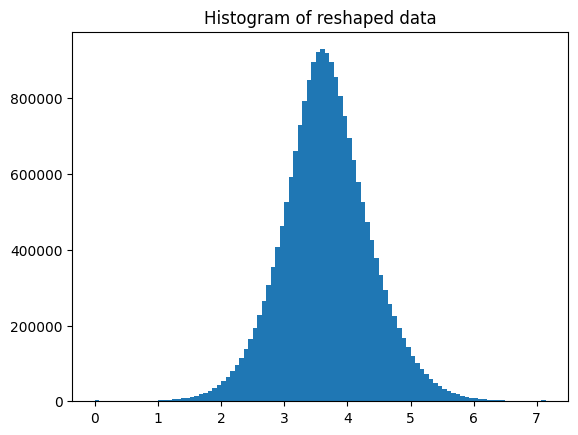

(1854, 281, 39)

In [14]:
average_concept_epochs = concept_epochs.mean(axis = 0)
print(average_concept_epochs.shape, concept_epochs.shape)
temp = average_concept_epochs
# set outlier points to max value 
dev = 5*np.std(temp)
temp[temp > dev] = dev
temp[temp < - dev] = - dev
temp = temp - np.min(temp)
plt.hist(temp.flatten(), bins = 100)
plt.title("Histogram of reshaped data")
plt.show()
temp.shape

In [15]:
# plt.title("Making sure reshaping keeps time data constant")
# plt.plot(time_points, X[0, :NOS_TIME_POINTS], label = 'reshaped data')
# plt.plot(time_points, average_concept_epochs[0, :, 0], label = 'original data')
# plt.legend()
# plt.show()

Trying NMF on a few time points


### NMF 

In [36]:
X = temp.transpose(0,2,1).reshape(NOS_CONCEPTS, NOS_TIME_POINTS * NOS_CHANNELS_OPT) 
X = X - X.min()
X.shape
images_to_show = 20
nmf_components = 6
BAYESIAN = False

if BAYESIAN:
    W, H = fit_bnmf(X, nmf_components)
    X_pred = np.dot(W, H)
else:
    model = NMF(n_components=nmf_components, random_state=40)
    model.init = 'random'  
    W = model.fit_transform(X)
    H = model.components_
    X_pred = np.dot(W, H)
# model = NMF(n_components=nmf_components, random_state=40)
# model.init = 'random'   
# W = model.fit_transform(X)
# H = model.components_
# X_pred = np.dot(W, H)
print(X.shape, W.shape, H.shape)

(1854, 10959) (1854, 6) (6, 10959)


/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


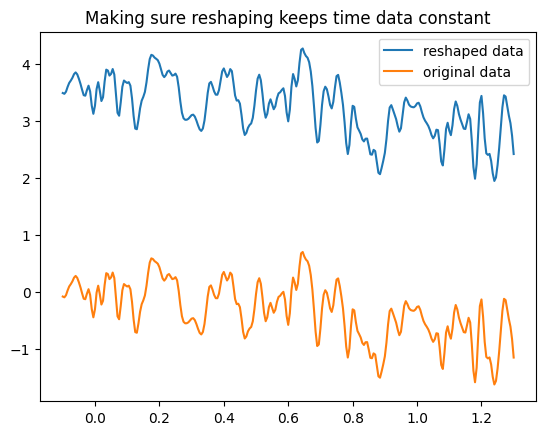

In [37]:
plt.title("Making sure reshaping keeps time data constant")
plt.plot(time_points, X[0, :NOS_TIME_POINTS], label = 'reshaped data')
plt.plot(time_points, average_concept_epochs[0, :, 0], label = 'original data')
plt.legend()
plt.show()

Categories which are best on component 0 are: [1388  694  981 1709  875  822  676  469 1496 1183  971 1280  330 1058
 1404  792 1656  669 1302 1464]
Categories which are best on component 1 are: [ 142 1148 1320 1347 1720 1738 1461  447  494   66 1798  676   53  105
  284  569 1227  963  372 1674]
Categories which are best on component 2 are: [1042 1433  742 1271  562  863  960   57 1343 1025  196  843 1483  666
  276 1620   11  915  119  313]
Categories which are best on component 3 are: [ 347 1283 1448    8 1502  686 1843 1838 1102  222 1009 1361  475 1485
 1467  558 1802 1362 1451  870]
Categories which are best on component 4 are: [ 430 1030  997  904  112 1497 1404  756 1164 1022  176  366  396  851
 1373 1153  761 1569   62  496]
Categories which are best on component 5 are: [ 909 1034  270 1537  526   10  437  323 1234 1590 1084  815 1613  564
 1816 1498 1093 1372 1803  501]
Component 0 is best loaded by the following image categories:


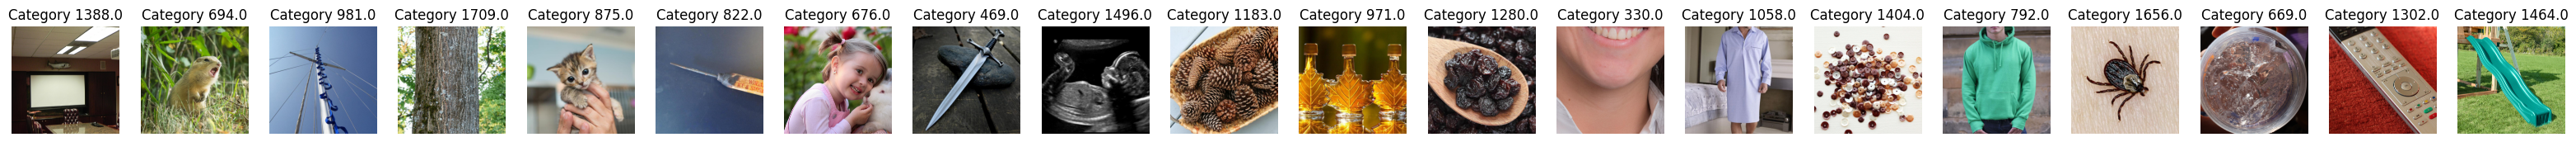

Component 1 is best loaded by the following image categories:


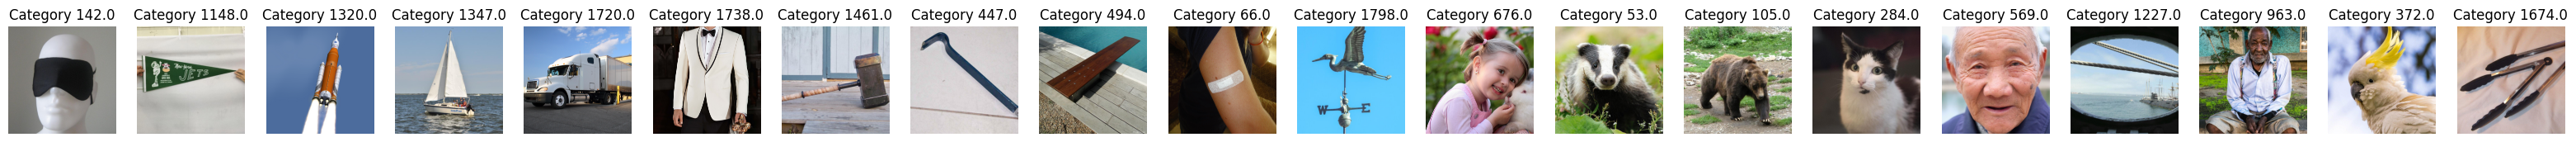

Component 2 is best loaded by the following image categories:


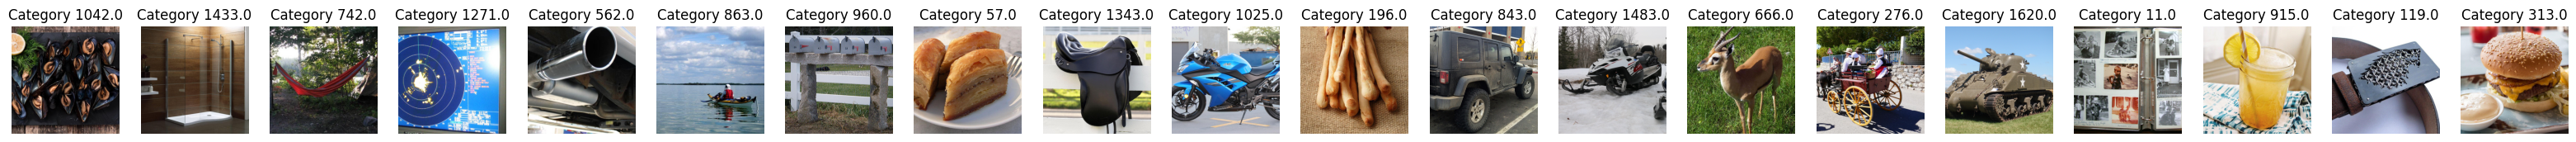

Component 3 is best loaded by the following image categories:


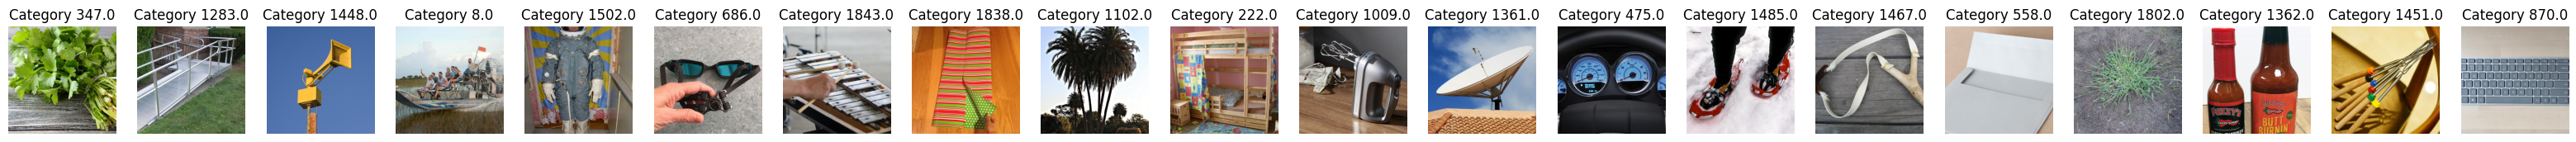

Component 4 is best loaded by the following image categories:


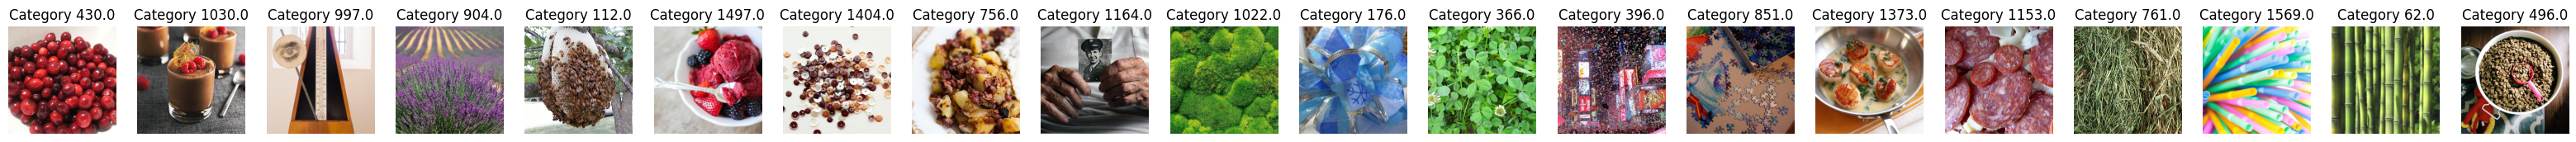

Component 5 is best loaded by the following image categories:


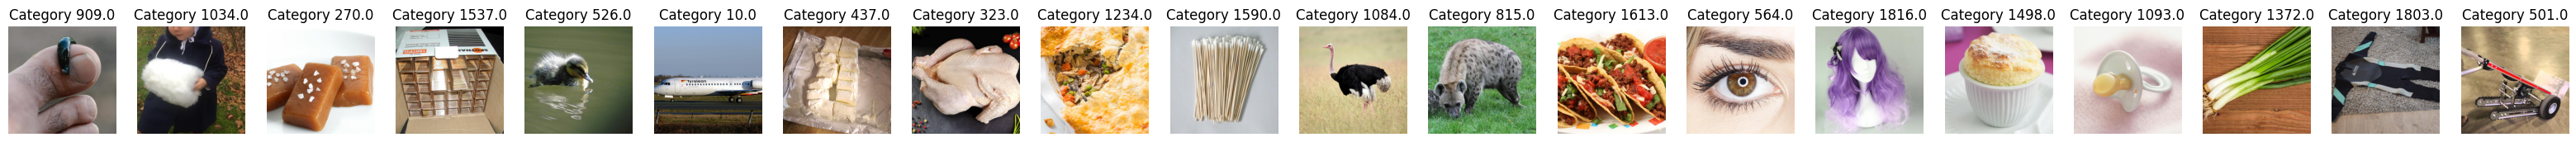

In [38]:

nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
for i in range(nmf_components):
    sorted_indices = np.argsort(W[:,i])
    print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
    nmf_components_vs_category[i,:] = sorted_indices[-images_to_show:]
# plot images for the top 5 categories for each component   
for component in range(nmf_components):
    if component > 20:
        break
    print(f"Component {component} is best loaded by the following image categories:")
    fig, axs = plt.subplots(1, images_to_show, figsize=(40, 40))
    for i in range(images_to_show):
        category_nr = nmf_components_vs_category[component, i] 
        # Get the image paths for the given category_nr
        image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
        image_path = image_paths.iloc[0]
        image_path = f'{image_dir}{image_path}'
        img = mpimg.imread(image_path)
        axs[i].imshow(img)
        axs[i].set_title(f"Category {category_nr}")
        axs[i].axis('off')
    plt.show()

### Time dynamics
To see how each component evolves with time

In [39]:
print(H.shape)
comp_vs_time = H.reshape(nmf_components, NOS_CHANNELS_OPT, NOS_TIME_POINTS)


(6, 10959)


In [40]:
nmf_components

6

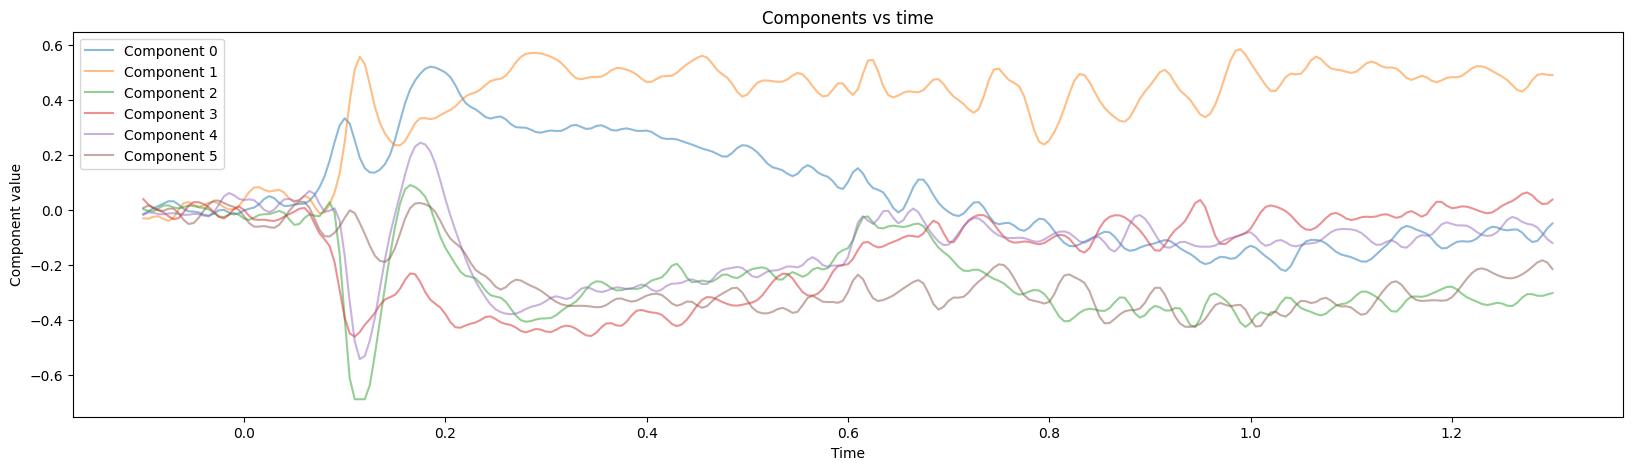

In [41]:

plt.figure(figsize=(20, 5)) 
# plt.plot(time_points, average_concept_epochs[0, :, 0], label = 'original data', linewidth=2)
# plt.plot(time_points, comp_vs_time[:, 0,:].sum(axis=0), label = 'NMF reconstruction', linewidth=2)
for i in range(nmf_components):
    # plt.plot(time_points, comp_vs_time[i, 0,:], alpha=0.5, label=f'Component {i}')   
    plt.plot(time_points, comp_vs_time[i, 0,:] - comp_vs_time[i,0,:20].mean(), alpha=0.5, label=f'Component {i}')
plt.title("Components vs time")
plt.xlabel("Time")
plt.ylabel("Component value")
plt.legend()
plt.show()

In [42]:
# similarity matrix instead of reconstructing data matrix 

In [43]:
# correlation of dimensions with the categories

In [44]:
times = [-0.1,0.0, 0.170, 0.320, 0.5, 0.75, 1, 1.2]
nmf_components = 4 # 3 mins for 30 components

for time in times:
    index = epochs.times == time
    X = average_concept_epochs[:, index, :].squeeze()
    X += abs(X.min())
    model = NMF(n_components=nmf_components)
    W = model.fit_transform(X)
    H = model.components_
    X_pred = np.dot(W, H)   
    nmf_components_vs_category = np.zeros((nmf_components, 10))
    print(f'For time {time*1000} ms')
    for i in range(nmf_components):
        sorted_indices = np.argsort(W[:,i])
        # print(f'Categories which are best on component {i} are: {sorted_indices[-10:]}')
        nmf_components_vs_category[i,:] = sorted_indices[-10:]
    # plot images for the top 5 categories for each component   
    for component in range(nmf_components):
        if component > 20:
            break
        print(f"Component {component} is best loaded by the following image categories:")
        # fig, axs = plt.subplots(1, 10, figsize=(20, 20))
        for i in range(10):
            category_nr = nmf_components_vs_category[component, i] 
            # Get the image paths for the given category_nr
            image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
            print(image_paths)
            # print(image_paths.iloc[0])
            # image_path = image_paths.iloc[0]
            # image_path = f'../{image_path}'
            # img = mpimg.imread(image_path)
            # axs[i].imshow(img)
            # axs[i].set_title(f"Category {category_nr}")
            # axs[i].axis('off')
        # plt.show()

/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For time -100.0 ms
Component 0 is best loaded by the following image categories:
939      images_meg/sickle/sickle_06s.jpg
3930     images_meg/sickle/sickle_10s.jpg
6224     images_meg/sickle/sickle_03s.jpg
6996     images_meg/sickle/sickle_04s.jpg
10061    images_meg/sickle/sickle_01b.jpg
11539    images_meg/sickle/sickle_11s.jpg
14558    images_meg/sickle/sickle_07s.jpg
16182    images_meg/sickle/sickle_09s.jpg
20232    images_meg/sickle/sickle_05s.jpg
22488    images_meg/sickle/sickle_02s.jpg
23700    images_meg/sickle/sickle_12s.jpg
27025    images_meg/sickle/sickle_08s.jpg
Name: image_path, dtype: object
968      images_meg/water_filter/water_filter_06s.jpg
3846     images_meg/water_filter/water_filter_10s.jpg
5954     images_meg/water_filter/water_filter_03s.jpg
6884     images_meg/water_filter/water_filter_04s.jpg
11104    images_meg/water_filter/water_filter_01b.jpg
12360    images_meg/water_filter/water_filter_11s.jpg
13986    images_meg/water_filter/water_filter_07s.jpg
17057

/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


963      images_meg/stove2/stove2_06s.jpg
3103     images_meg/stove2/stove2_10s.jpg
4595     images_meg/stove2/stove2_03s.jpg
8369     images_meg/stove2/stove2_04s.jpg
9383     images_meg/stove2/stove2_01b.jpg
12121    images_meg/stove2/stove2_11s.jpg
15173    images_meg/stove2/stove2_07s.jpg
16573    images_meg/stove2/stove2_09s.jpg
19470    images_meg/stove2/stove2_05s.jpg
20793    images_meg/stove2/stove2_02s.jpg
24269    images_meg/stove2/stove2_12s.jpg
24917    images_meg/stove2/stove2_08s.jpg
Name: image_path, dtype: object
Component 3 is best loaded by the following image categories:
1715     images_meg/speedboat/speedboat_06s.jpg
3520     images_meg/speedboat/speedboat_10s.jpg
5065     images_meg/speedboat/speedboat_03s.jpg
8145     images_meg/speedboat/speedboat_04s.jpg
9738     images_meg/speedboat/speedboat_01s.jpg
11986    images_meg/speedboat/speedboat_11s.jpg
13694    images_meg/speedboat/speedboat_07s.jpg
17561    images_meg/speedboat/speedboat_09s.jpg
18183    images_me

/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For time 500.0 ms
Component 0 is best loaded by the following image categories:
1725     images_meg/exerciser/exerciser_06s.jpg
3838     images_meg/exerciser/exerciser_10s.jpg
6649     images_meg/exerciser/exerciser_03s.jpg
7352     images_meg/exerciser/exerciser_04s.jpg
9432     images_meg/exerciser/exerciser_01b.jpg
12134    images_meg/exerciser/exerciser_11s.jpg
15634    images_meg/exerciser/exerciser_07s.jpg
16099    images_meg/exerciser/exerciser_09s.jpg
20012    images_meg/exerciser/exerciser_05s.jpg
21415    images_meg/exerciser/exerciser_02s.jpg
24586    images_meg/exerciser/exerciser_12s.jpg
25034    images_meg/exerciser/exerciser_08s.jpg
Name: image_path, dtype: object
1465     images_meg/racket/racket_06s.jpg
2465     images_meg/racket/racket_10s.jpg
6730     images_meg/racket/racket_03s.jpg
7443     images_meg/racket/racket_04s.jpg
9247     images_meg/racket/racket_01b.jpg
13109    images_meg/racket/racket_11s.jpg
15130    images_meg/racket/racket_07s.jpg
16701    images_me

/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/asuryawanshi/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


1566     images_meg/horse/horse_06s.jpg
4505     images_meg/horse/horse_10s.jpg
5501     images_meg/horse/horse_03s.jpg
7749     images_meg/horse/horse_04s.jpg
9589     images_meg/horse/horse_01b.jpg
11658    images_meg/horse/horse_11s.jpg
14579    images_meg/horse/horse_07s.jpg
17161    images_meg/horse/horse_09s.jpg
19122    images_meg/horse/horse_05s.jpg
21576    images_meg/horse/horse_02s.jpg
24040    images_meg/horse/horse_12s.jpg
26281    images_meg/horse/horse_08s.jpg
Name: image_path, dtype: object
2168     images_meg/ham/ham_06s.jpg
3807     images_meg/ham/ham_10s.jpg
6586     images_meg/ham/ham_03s.jpg
8679     images_meg/ham/ham_04s.jpg
9804     images_meg/ham/ham_01b.jpg
13019    images_meg/ham/ham_11s.jpg
14585    images_meg/ham/ham_07s.jpg
17415    images_meg/ham/ham_09s.jpg
20156    images_meg/ham/ham_05s.jpg
21609    images_meg/ham/ham_02s.jpg
23275    images_meg/ham/ham_12s.jpg
25314    images_meg/ham/ham_08s.jpg
Name: image_path, dtype: object
1028     images_meg/pom-